# Probability of Default Model

Here we will assess the dynamic hurricane risk index and its effect it has on the probability of default. The goal is to measure the effect of the DHRI on the probability of default. Moreover, we will compare this model to a model using actual HRCN frequency data.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import linearmodels as lm
import statsmodels.api as sm
from linearmodels import PanelOLS
from linearmodels import RandomEffects
from linearmodels import PooledOLS
from linearmodels import FirstDifferenceOLS
from linearmodels import BetweenOLS
from linearmodels import FamaMacBeth
import sqlite3

Set Parameters:

In [2]:
db_path = "../Database/thesis_database.db"
conn = sqlite3.connect(db_path)

In [9]:
years = range(1999,2023)
union_query = [f"SELECT * FROM fm_{year}" for year in years]
combined_query = " UNION ALL ".join(union_query)
#query that binds fm_2022 and fm_2021
query = f"""
SELECT 
    fm_combined."3ZIP",
    fm_combined."Date",
    COUNT(DISTINCT LSN) AS UNQ_LSN,
    AVG(CIR) AS AVG_CIR,
    AVG(CLTV) AS AVG_CLTV,
    AVG(OIR) AS AVG_OIR,
    AVG(LTV) AS AVG_LTV,
    AVG(DTI) AS AVG_DTI,
    SUM(D90) AS SUM_D90,
    SUM(D180) AS SUM_D180,
    AVG(HRCN_RISKS) AS HRCN_RISKS, 
    AVG(HRCN_RISKV) AS HRCN_RISKV,
    AVG(HRCN_EVNTS) AS HRCN_EVNTS,
    AVG(HRCN_EALS) AS HRCN_EALS
FROM fm_combined
INNER JOIN hrcn_data_short
ON fm_combined."3ZIP" = hrcn_data_short."3ZIP"
GROUP BY fm_combined."DATE", fm_combined."3ZIP";
"""

fm_agg_hrcn_date = pd.read_sql_query(query, conn)
##Takes around 36 mins to run

In [6]:
fm_agg = pd.read_csv("../Data/fm_agg.csv")

In [5]:
#fm_agg.to_sql("fm_combined", conn, if_exists="replace", index=False)

63161343

In [ ]:
query_fm_agg = """
SELECT *
FROM fm_combined
"""

In [3]:
#Open SQL connection
query_hrcn = """
SELECT * 
FROM hrcn_data_short
"""
hrcn_data = pd.read_sql_query(query_hrcn, conn)

#Join fm_agg with hrcn_data_short on 3ZIP.

In [4]:
#load fm_agg.csv, 3ZIP as object
fm_agg = pd.read_csv("../Data/fm_agg.csv", dtype={"3ZIP": str})

KeyboardInterrupt: 

In [7]:
hrcn_data["3ZIP"] = hrcn_data["3ZIP"].astype(str)

In [8]:
#get different lengths of 3ZIP
#find 3zip of length 2
fm_agg.dtypes
hrcn_data.dtypes

3ZIP           object
HRCN_RISKS    float64
HRCN_RISKV    float64
HRCN_EVNTS    float64
HRCN_EALS     float64
dtype: object

In [11]:
#save fm_agg_hrcn
fm_agg_hrcn.to_csv("../Data/fm_hrcn.csv", index=False)

In [5]:
fm_agg_hrcn = pd.read_csv("../Data/fm_hrcn.csv")

In [3]:
query = """
SELECT *
FROM enso_mei_long
"""
enso_mei_long = pd.read_sql_query(query, conn)

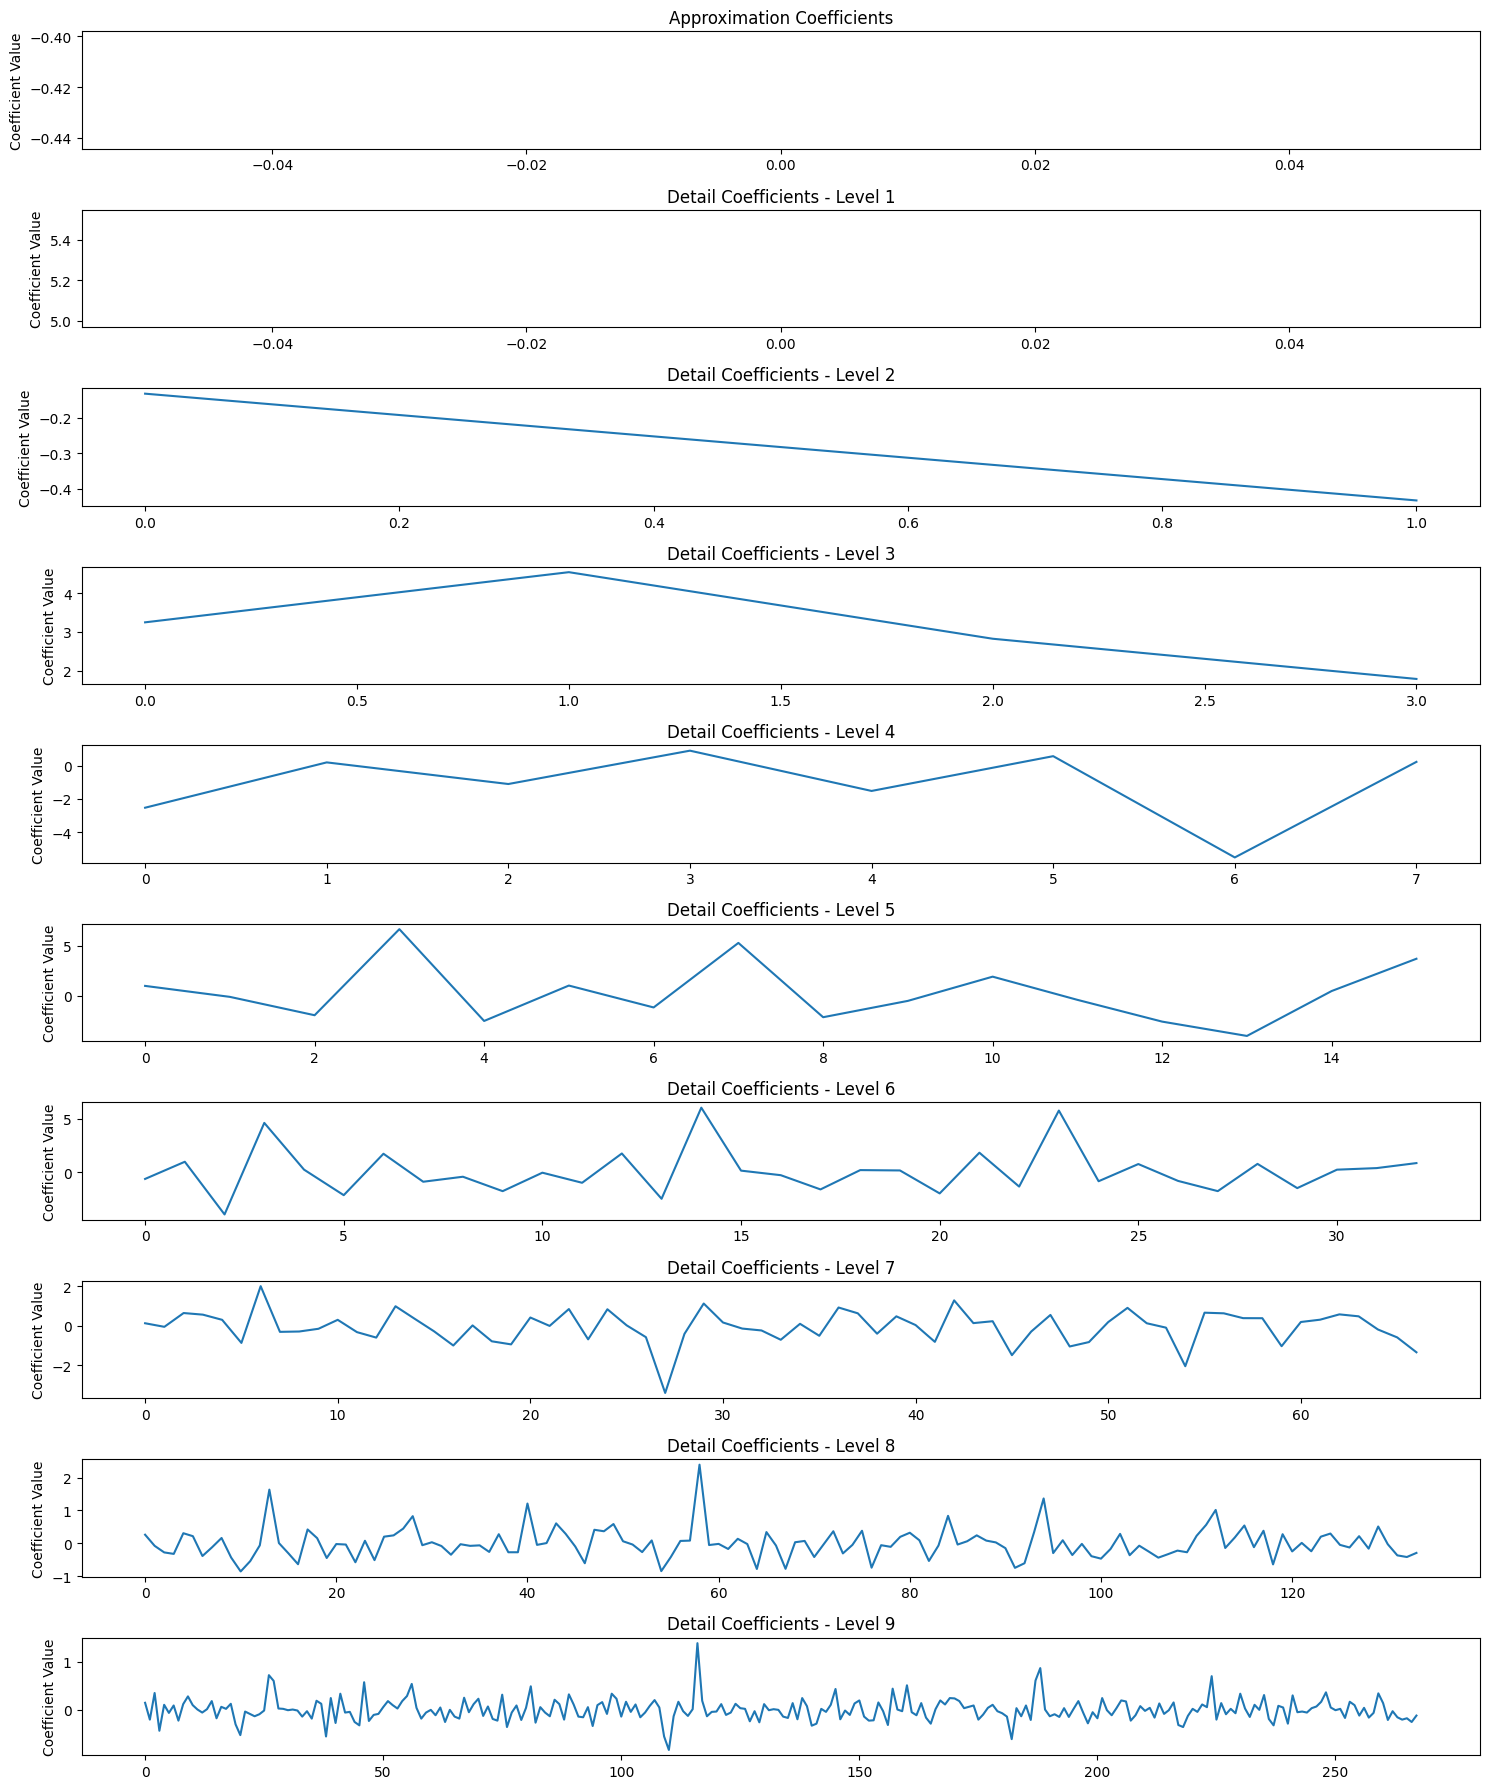

In [7]:
#convert date to datetime
enso_mei_long['Date'] = pd.to_datetime(enso_mei_long['Date'], format = '%Y%m')
#merge Mei with fm_agg_hrcn left merge
fm_agg_hrcn['Date'] = pd.to_datetime(fm_agg_hrcn['Date'])

fm_agg_hrcn_mei = pd.merge(fm_agg_hrcn, enso_mei_long, on='Date', how = 'left')


In [4]:
conn.close()

NameError: name 'conn' is not defined

### Using HDRI

In [15]:
fm_agg_hrcn['SUM_D90'] / fm_agg_hrcn['UNQ_LSN']*100

0         0.000000
1         0.000000
2         0.000000
3         0.000000
4         0.000000
            ...   
142135    0.532623
142136    0.000000
142137    0.000000
142138    0.000000
142139    0.000000
Length: 142140, dtype: float64

In [48]:
#Set multiindex 3ZIP and Date
fm_agg_hrcn_mei['DHRI'] = (fm_agg_hrcn_mei['HRCN_EALS'])*fm_agg_hrcn_mei['MEI']
fm_agg_hrcn_mei = fm_agg_hrcn_mei.set_index(['3ZIP', 'Date'])

In [72]:
#from HPI_maseter.csv import sheet HPI_quarter
hpi_quarter = pd.read_excel("../Data/HPI_master.xls")
#merge 
fm_agg_hrcn['quarter'] = (fm_agg_hrcn['Date'].dt.month - 1) // 3 + 1


#load ZIP_COUNTY_062023.xlsx
zip_county = pd.read_excel('../Data/ZIP_COUNTY_062023.xlsx', dtype={'3ZIP': str, 'COUNTY': str,'ZIP': str})
import functions as f
hpi_quarter['3ZIP'] = hpi_quarter['place_id'].apply(f.county_to_zip, zip_data=zip_county)

IndexError: index 0 is out of bounds for axis 0 with size 0

In [60]:
mod = PanelOLS(dependent=fm_agg_hrcn_mei['SUM_D90'], exog=fm_agg_hrcn_mei[['MEI', 'AVG_LTV', '']])

res = mod.fit()
print(res)

                          PanelOLS Estimation Summary                           
Dep. Variable:                SUM_D90   R-squared:                        0.0450
Estimator:                   PanelOLS   R-squared (Between):              0.2778
No. Observations:              142140   R-squared (Within):               0.0003
Date:                Thu, Oct 19 2023   R-squared (Overall):              0.0450
Time:                        13:20:59   Log-likelihood                -4.321e+05
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      3348.5
Entities:                         493   P-value                           0.0000
Avg Obs:                       288.32   Distribution:                F(2,142138)
Min Obs:                       162.00                                           
Max Obs:                       290.00   F-statistic (robust):             3348.5
                            

In [54]:
mod = RandomEffects(dependent=fm_agg_hrcn_mei['SUM_D90'] / fm_agg_hrcn_mei['UNQ_LSN']*100, exog=fm_agg_hrcn_mei[['DHRI']])
res = mod.fit()
print(res)


                        RandomEffects Estimation Summary                        
Dep. Variable:                      0   R-squared:                        0.0002
Estimator:              RandomEffects   R-squared (Between):              0.0308
No. Observations:              142140   R-squared (Within):           -2.458e-05
Date:                Thu, Oct 19 2023   R-squared (Overall):              0.0015
Time:                        13:17:26   Log-likelihood                -3.116e+05
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      22.671
Entities:                         493   P-value                           0.0000
Avg Obs:                       288.32   Distribution:                F(1,142139)
Min Obs:                       162.00                                           
Max Obs:                       290.00   F-statistic (robust):             22.671
                            

In [37]:
mod = PooledOLS(dependent=fm_agg_hrcn_mei['SUM_D90'] / fm_agg_hrcn_mei['UNQ_LSN'], exog=fm_agg_hrcn_mei[['AVG_OIR', 'AVG_CLTV', 'AVG_DTI','AVG_LTV', 'MEI', 'DHRI']])
res = mod.fit()
print(res)


                          PooledOLS Estimation Summary                          
Dep. Variable:                      0   R-squared:                        0.0286
Estimator:                  PooledOLS   R-squared (Between):              0.5818
No. Observations:              142140   R-squared (Within):               0.0007
Date:                Thu, Oct 19 2023   R-squared (Overall):              0.0286
Time:                        13:11:39   Log-likelihood                 3.419e+05
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      698.26
Entities:                         493   P-value                           0.0000
Avg Obs:                       288.32   Distribution:                F(6,142134)
Min Obs:                       162.00                                           
Max Obs:                       290.00   F-statistic (robust):             698.26
                            

In [42]:
mod = FirstDifferenceOLS(dependent=fm_agg_hrcn_mei['SUM_D90'] / fm_agg_hrcn_mei['UNQ_LSN'], exog=fm_agg_hrcn_mei[['AVG_OIR', 'AVG_CLTV', 'AVG_DTI','AVG_LTV', 'MEI', 'DHRI']])
print(res)


                        RandomEffects Estimation Summary                        
Dep. Variable:                      0   R-squared:                        0.0051
Estimator:              RandomEffects   R-squared (Between):              0.5884
No. Observations:              142140   R-squared (Within):               0.0002
Date:                Thu, Oct 19 2023   R-squared (Overall):              0.0285
Time:                        13:13:46   Log-likelihood                 3.431e+05
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      181.52
Entities:                         493   P-value                           0.0000
Avg Obs:                       288.32   Distribution:                F(4,142136)
Min Obs:                       162.00                                           
Max Obs:                       290.00   F-statistic (robust):             181.52
                            